In [3]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2


## Neuron Ablation

Neuron count 2: Mean=50.00%, SD=0.00% from 5 samples
Neuron count 3: Mean=78.02%, SD=0.57% from 5 samples
Neuron count 4: Mean=72.11%, SD=1.56% from 5 samples
Neuron count 5: Mean=79.10%, SD=1.31% from 5 samples
Neuron count 6: Mean=69.01%, SD=1.82% from 5 samples
Neuron count 7: Mean=74.39%, SD=2.23% from 5 samples
Neuron count 8: Mean=74.86%, SD=2.15% from 5 samples
Neuron count 9: Mean=69.19%, SD=1.25% from 5 samples
Neuron count 10: Mean=73.63%, SD=2.06% from 5 samples


/var/folders/g4/b0tp89t57dbbzgsx2sl8tcq00000gn/T/ipykernel_72720/624588671.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


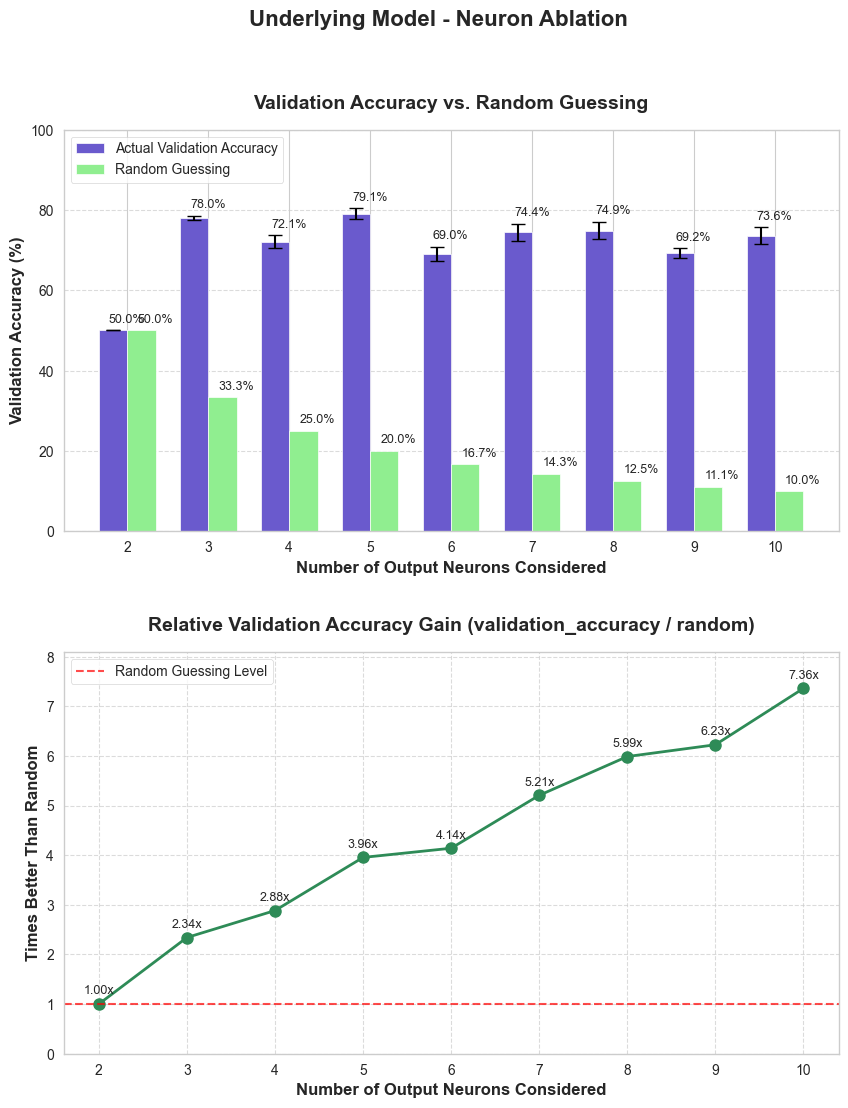

In [17]:


# Set style for better-looking plots
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Load data
df_ablation_results = pd.read_csv('../data/output-classes/mnist_ablation_results.csv')

# Group data by neuron count
neurons = list(range(2, 11))
results = []

for n in neurons:
    # Filter data for this neuron count
    neuron_data = df_ablation_results[df_ablation_results['num_neurons'] == n]
    
    # Calculate mean and standard deviation of validation accuracy
    acc_mean = neuron_data['valid_acc'].mean()
    acc_std = neuron_data['valid_acc'].std(ddof=1)  # Using sample standard deviation
    
    # Print information for verification
    print(f"Neuron count {n}: Mean={acc_mean*100:.2f}%, SD={acc_std*100:.2f}% from {len(neuron_data)} samples")
    
    # Calculate random guessing validation accuracy
    random_guess = 1/n
    
    # Calculate gains over random guessing
    additive_gain = acc_mean - random_guess
    relative_gain = acc_mean / random_guess
    
    results.append({
        'neurons': n,
        'validation_accuracy': acc_mean * 100,  # Convert to percentage
        'std_dev': acc_std * 100,  # Convert to percentage
        'random_guess': random_guess * 100,  # Convert to percentage
        'additive_gain': additive_gain * 100,  # How many percentage points above random
        'relative_gain': relative_gain  # How many times better than random
    })

# Convert to DataFrame and sort by neuron count
ablation_results_df_input_pixels = pd.DataFrame(results)
ablation_results_df = ablation_results_df.sort_values('neurons')

# Create a nice figure with 2 subplots in a grid
fig = plt.figure(figsize=(10, 12))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Plot 1: Validation Accuracy vs Random Guessing
ax1 = plt.subplot(gs[0])

# Set width of bars
barWidth = 0.35
r1 = np.arange(len(neurons))
r2 = [x + barWidth for x in r1]

# Create grouped bars
ax1.bar(r1, ablation_results_df['validation_accuracy'], width=barWidth, color='#6A5ACD', 
       yerr=ablation_results_df['std_dev'], capsize=5, label='Actual Validation Accuracy')
ax1.bar(r2, ablation_results_df['random_guess'], width=barWidth, color='#90EE90', label='Random Guessing')

# Add labels and title
ax1.set_xlabel('Number of Output Neurons Considered', fontweight='bold')
ax1.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax1.set_title('Validation Accuracy vs. Random Guessing', fontweight='bold', pad=15)
ax1.set_xticks([r + barWidth/2 for r in range(len(neurons))])
ax1.set_xticklabels(neurons)
ax1.set_ylim(0, 100)

# Add gridlines
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add a legend
ax1.legend(loc='upper left')

# Add value labels above bars
for i, v in enumerate(ablation_results_df['validation_accuracy']):
    ax1.text(i - 0.05, v + 2 + ablation_results_df['std_dev'].iloc[i], f"{v:.1f}%", fontsize=9)
for i, v in enumerate(ablation_results_df['random_guess']):
    ax1.text(i + barWidth - 0.05, v + 2, f"{v:.1f}%", fontsize=9)

# Plot 2: Relative Gain
ax2 = plt.subplot(gs[1])
ax2.plot(neurons, ablation_results_df['relative_gain'], 'o-', color='#2E8B57', linewidth=2, markersize=8)

# Add horizontal line at y=1 (random guessing performance)
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Random Guessing Level')

# Add labels and title
ax2.set_xlabel('Number of Output Neurons Considered', fontweight='bold')
ax2.set_ylabel('Times Better Than Random', fontweight='bold')
ax2.set_title('Relative Validation Accuracy Gain (validation_accuracy / random)', fontweight='bold', pad=15)
ax2.set_xticks(neurons)
ax2.set_ylim(0, ablation_results_df['relative_gain'].max() * 1.1)

# Add gridlines
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels above points
for i, v in enumerate(ablation_results_df['relative_gain']):
    ax2.text(neurons[i], v + 0.2, f"{v:.2f}x", ha='center', fontsize=9)

# Add a legend
ax2.legend(loc='upper left')

# Add overall title
plt.suptitle('Underlying Model - Neuron Ablation', fontsize=16, fontweight='bold', y=0.98)

# Adjust layout and save
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('../images/fig4.png', dpi=300, bbox_inches='tight')
plt.show()

## Input-layer task

### Plot R2 score based on mse and label variance

In [4]:
def idx2xy(i: int, width: int = 27) -> tuple[int, int]:
    """Convert flat index -> (x, y) using row‑major order."""
    return (i % width, i // width)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_input_pixel_results(data_sources, title, targets):
    """
    Load input pixel decoding results, calculate R² scores, and create visualization plots.

    Args:
        data_sources (list): List of data source identifiers (e.g., ['dropout', 'no-dropout', 'untrained'])
        title (str): The title for the plot (e.g., 'Pixel Intensities').
        targets (np.array): The target values for the pixel map, used for label_variance and plotting.
    """
    # Define standard column names
    column_names = ['step', 'mean_mse', 'max_mse', 'min_mse']

    # compute label variance
    label_variance_val = np.var(targets)

    # --- Load data and calculate R2 scores in a loop ---
    input_pixels_results_dfs = {}
    for file_name in data_sources:
        # Construct file path
        file_path = f'../data/input-pixels/{file_name}.csv'
        # Split by the last '-' and take everything before it
        label = file_name.replace('-y', '')
        # Read CSV
        try:
            df_input_pixels = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping this data source: {file_name}")
            continue
        # Set column names
        df_input_pixels.columns = column_names
        # Calculate R2 scores
        df_input_pixels['mean_r2'] = 1.0 - (df_input_pixels['mean_mse'] / label_variance_val)
        # For fill_between: min_r2 is the lower R2 value (from max_mse), max_r2 is the higher R2 value (from min_mse)
        df_input_pixels['min_r2'] = 1.0 - (df_input_pixels['max_mse'] / label_variance_val)
        df_input_pixels['max_r2'] = 1.0 - (df_input_pixels['min_mse'] / label_variance_val)
        # Store the processed dataframe
        input_pixels_results_dfs[label] = df_input_pixels

    if not input_pixels_results_dfs:
        print("No data was loaded. Skipping plot generation.")
        return

    # --- Plotting Code ---
    sns.set_style("whitegrid")

    # Define font sizes - increased
    title_fontsize = 22
    label_fontsize = 18
    tick_fontsize = 16
    legend_fontsize = 16

    # Define plot colors and styles dynamically based on the actual labels to be plotted
    # These are the keys from input_pixels_results_dfs
    actual_plot_labels = list(input_pixels_results_dfs.keys())

    color_options = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    linestyle_options = ['--', '-', ':', '-.']
    alpha_options = [0.2, 0.15, 0.1, 0.25]
    linewidth_options = [2.5, 2.5, 2.5, 2.5]

    colors = {lbl: color_options[i % len(color_options)] for i, lbl in enumerate(actual_plot_labels)}
    linestyles = {lbl: linestyle_options[i % len(linestyle_options)] for i, lbl in enumerate(actual_plot_labels)}
    alphas = {lbl: alpha_options[i % len(alpha_options)] for i, lbl in enumerate(actual_plot_labels)}
    linewidths = {lbl: linewidth_options[i % len(linewidth_options)] for i, lbl in enumerate(actual_plot_labels)}

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Add a figure-level title
    fig.suptitle(f"Decoding Input-Neuron {title}", fontsize=title_fontsize+2, y=0.98)

    # --- Plot 1: R² Score (Left subplot) ---
    ax1.set_xlabel('# Batches trained', fontsize=label_fontsize)
    ax1.set_ylabel('R² Score', fontsize=label_fontsize)

    # Plot data for each dataframe
    for label, df in input_pixels_results_dfs.items():
        # Plot the mean line
        ax1.plot(df['step'], df['mean_r2'],
                 label=f'{label} R²',
                 color=colors[label],
                 linestyle=linestyles[label],
                 linewidth=linewidths[label])

        # Add confidence interval (STD) band
        ax1.fill_between(df['step'], df['min_r2'], df['max_r2'],
                         color=colors[label],
                         alpha=alphas[label],
                         label=f'{label} Std Dev Range') # This label part might make legend busy

    # Set tick parameters
    ax1.tick_params(axis='y', labelsize=tick_fontsize)
    ax1.tick_params(axis='x', labelsize=tick_fontsize)
    ax1.set_title(f'Predicting {title} (R² Score)', fontsize=title_fontsize)

    # --- Plot 2: Targets (Right subplot) ---
    # Display pixel map
    pixel_map = np.zeros((28, 28), dtype=float)
    for i, value in enumerate(targets):
        x, y = idx2xy(i, width=28) # Ensure idx2xy is defined in your environment
        pixel_map[y, x] = value

    # Remove grid lines from the right plot
    ax2.grid(False)

    im = ax2.imshow(pixel_map, cmap='viridis', interpolation='nearest')
    cbar = plt.colorbar(im, ax=ax2)
    cbar.ax.tick_params(labelsize=tick_fontsize)
    ax2.set_title(f'{title} for input neurons', fontsize=title_fontsize)
    ax2.set_xlabel('Neuron X position', fontsize=label_fontsize)
    ax2.set_ylabel('Neuron Y position', fontsize=label_fontsize)
    ax2.tick_params(axis='both', labelsize=tick_fontsize)

    # Add Legend to the first subplot - simplified from original to avoid confusion
    # This will show labels for both mean lines and fill_between areas.
    # For a cleaner legend (e.g., only mean lines), more complex handle/label filtering is needed.
    handles, legend_labels = ax1.get_legend_handles_labels()
    # Filter to keep only unique "R²" mean lines for legend clarity
    unique_mean_handles = []
    unique_mean_labels = []
    seen_prefixes = set()
    for handle, current_label in zip(handles, legend_labels):
        if ' R²' in current_label:
            prefix = current_label.split(' R²')[0]
            if prefix not in seen_prefixes:
                unique_mean_handles.append(handle)
                unique_mean_labels.append(current_label)
                seen_prefixes.add(prefix)
    ax1.legend(unique_mean_handles, unique_mean_labels, loc='best', fontsize=legend_fontsize)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()

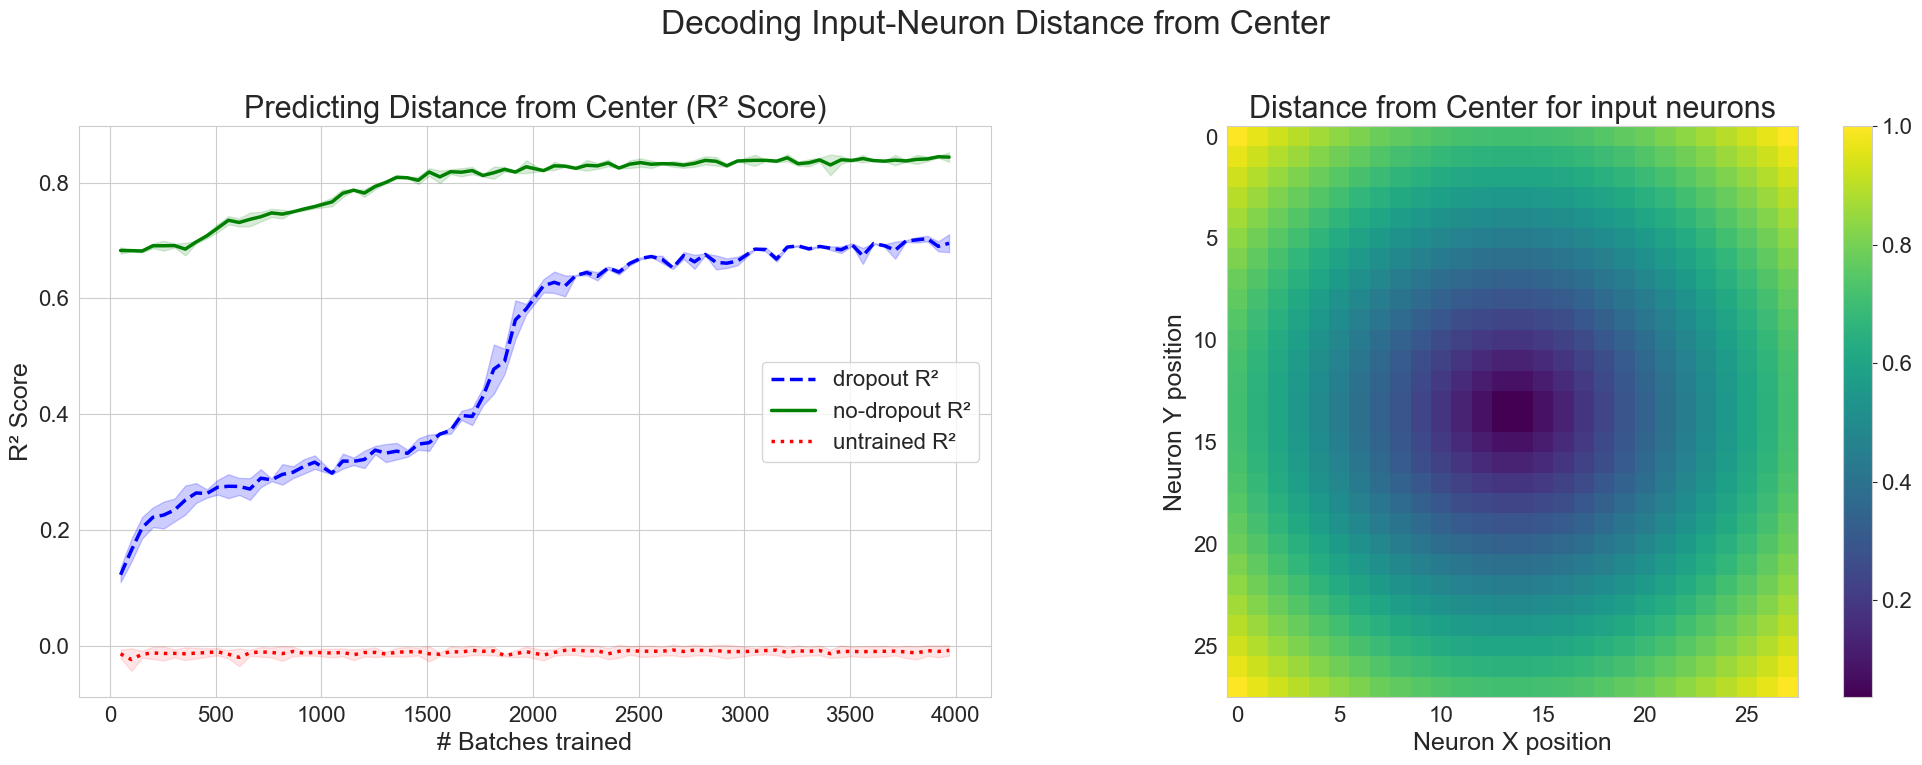

In [12]:
import math
distances_from_center = []
for i in range(28):
    for j in range(28):
        dist = math.sqrt((i - 13.5)**2 + (j - 13.5)**2)
        max_dist = math.sqrt(13.5**2 + 13.5**2)
        distances_from_center.append(dist/max_dist)

plot_input_pixel_results(['dropout', 'no-dropout', 'untrained'], title="Distance from Center", targets=distances_from_center)

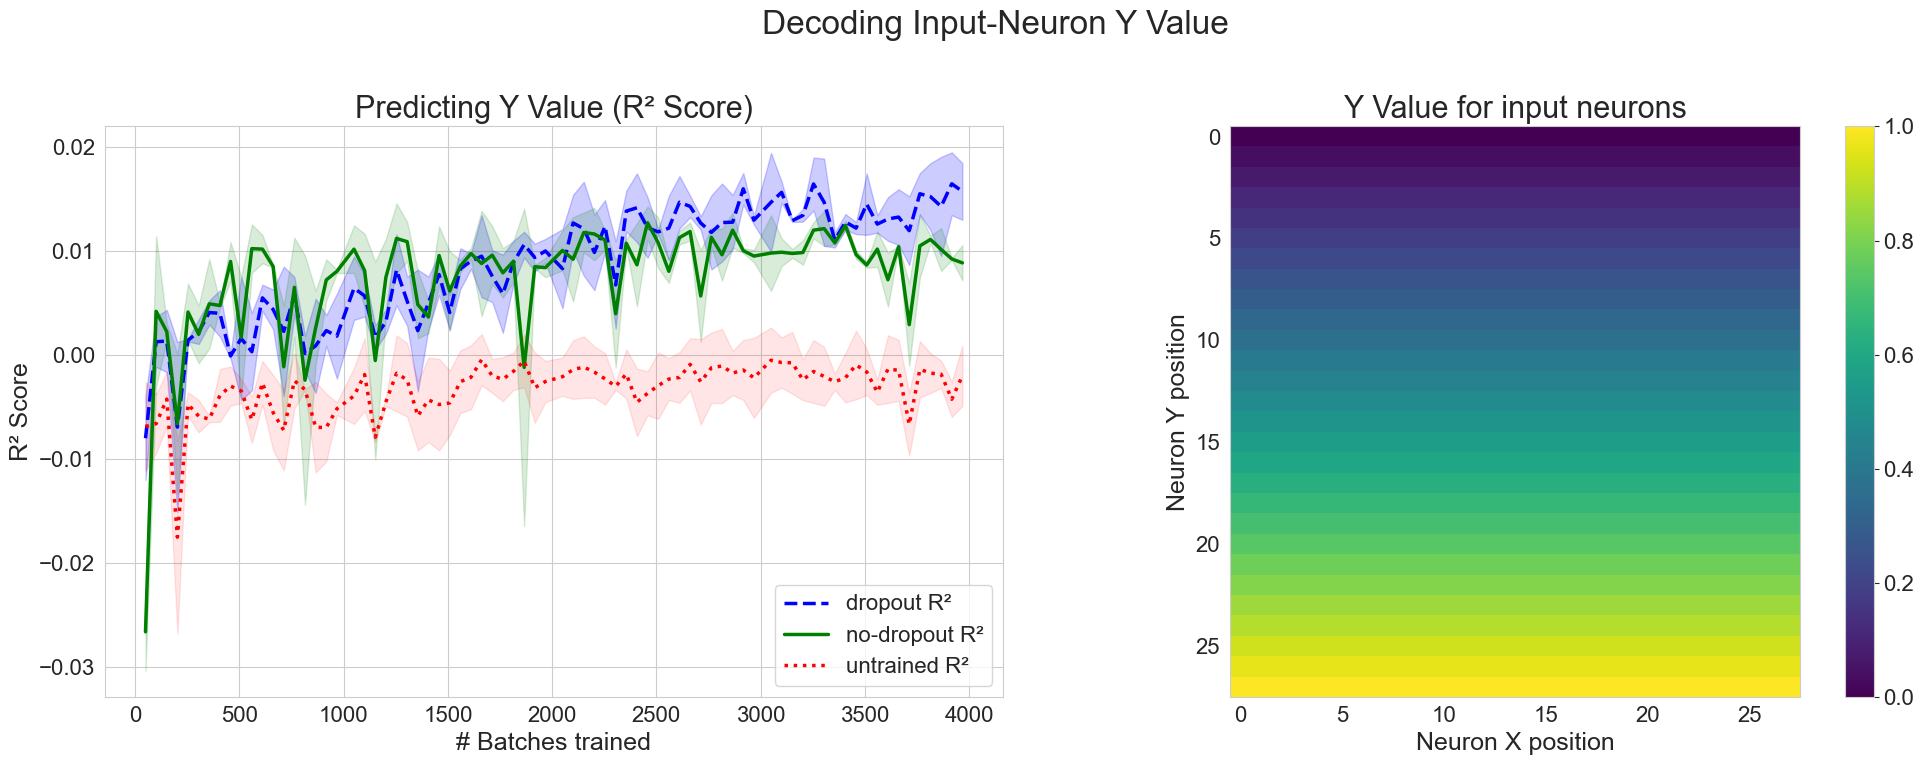

In [13]:
normalized_y = np.array([(j // 28) / (27) for j in range(784)], dtype=np.float32)
plot_input_pixel_results(['dropout-y', 'no-dropout-y', 'untrained-y'], title="Y Value", targets=normalized_y)

## Entropy Reduction

### Class ID

In [51]:
import pandas as pd, numpy as np, math

# 1. Load results
df_arc_classid = pd.read_csv("../data/output-classes/classid-decoding-accuracy-final.csv")

# 2. Helper: ARS ≥ 1 – [h_b(Pe)+Pe·log2(K–1)] / log2 K   (K = 10)
def ars_lb(acc, K=10):
    pe = 1.0 - acc
    hb = 0.0 if pe in (0, 1) else -(pe*math.log2(pe) + (1-pe)*math.log2(1-pe))
    return 1.0 - (hb + pe*math.log2(K-1)) / math.log2(K)

# 3. Label experiment type
df_arc_classid["condition"] = np.select(
    [df_arc_classid["untrained"], df_arc_classid["model_class_str"] == "fully_connected_dropout"],
    ["untrained", "dropout"],
    default="no_dropout",
)

# 4. Compute ARS lower bound per run
df_arc_classid["ARS_lb"] = df_arc_classid["valid_acc"].apply(ars_lb)

df_classid_stats = (
    df_arc_classid
      .groupby("condition")
      .agg(
          acc_mean = ('valid_acc', 'mean'),
          acc_std  = ('valid_acc', 'std'),
          ars_mean = ('ARS_lb',    'mean'),
          ars_std  = ('ARS_lb',    'std'),
      )
      .round(3)          # keep three decimals
      .reset_index()
)
df_classid_stats


,condition,acc_mean,acc_std,ars_mean,ars_std
0,dropout,0.743,0.011,0.507,0.015
1,no_dropout,0.238,0.009,0.035,0.004
2,untrained,0.094,0.007,0.000,0.000


### Input pixel

In [53]:
final_r2_values = {}
for label in input_pixels_results_dfs.keys():
    final_r2_values[label] = input_pixels_results_dfs[label]['mean_r2'].values[-1]
final_r2_values


{'dropout': np.float64(0.6952242787324303),
 'no-dropout': np.float64(0.8438384076205453),
 'untrained': np.float64(-0.007526414728871389)}

In [54]:
distances_from_center_numpy = np.asarray(distances_from_center)
sigma = distances_from_center_numpy.std(ddof=0)
d_std = distances_from_center_numpy / sigma
sigma2 = 1.0
denom  = math.log2(2*math.pi*math.e*sigma2)   # ≈ 2.048 bits


# 3. lower-bound ARS for each run:  log2[1/(1–R²)] / denom
def ars_lb_r2(r2):
    num = math.log2(1.0 / (1.0 - r2))
    return max(0.0, min(1.0, num / denom))   # clip to [0, 1]

for label, r2 in final_r2_values.items():
    print(f"{label:12s}  R²={r2:.3f}  ARS ≥ {ars_lb_r2(r2):.3f}")

dropout       R²=0.695  ARS ≥ 0.419
no-dropout    R²=0.844  ARS ≥ 0.654
untrained     R²=-0.008  ARS ≥ 0.000


In [55]:
# build the dataframe
df = (pd.Series(final_r2_values, name="R2")
        .reset_index()
        .rename(columns={"index": "condition"}))
df["ARS_lb"] = df["R2"].apply(ars_lb_r2).round(3)

print(df)

    condition        R2  ARS_lb
0     dropout  0.695224   0.419
1  no-dropout  0.843838   0.654
2   untrained -0.007526   0.000
